# Monte Carlo model of DNA in comet images

Generate uniform distribution of DNA strands in cell/nucleus of radius `radCell`. There are 92 strands in human cells! 

Date and time  2023-01-02 15:08:34.828925
 
 
Image of example comet from ../../CometImages/comparisonImages/AB/4GyC0022.bmp


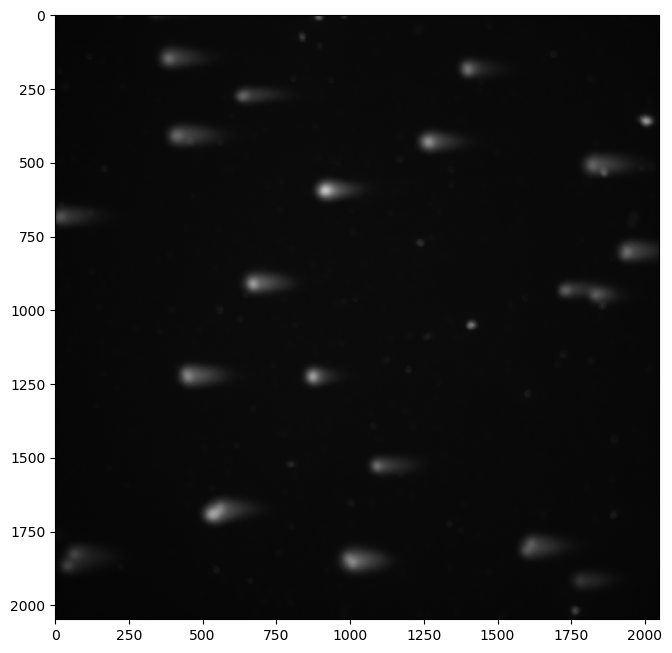

 
Date and time 2023-01-02 15:08:35.389417
Time since last check is 0:00:00.560492


In [6]:
%matplotlib inline
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
print(" ")
#
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy
from image_noise import noisy
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import cv2

plt.rcParams['figure.figsize'] = [12, 8]
# 
# Set image resolution, note that 200 dpi os a lot slower than 100 dpi!
plt.rcParams['figure.dpi'] = 100 # dpi
#
#path = "../CometImages/1st-set/Irradiated/*.bmp"
path = "../../CometImages/comparisonImages/AB/*.bmp"
images = (glob.glob(path))
#
# Choose an image and a typical comet within that image for comparison
print(" ")
print("Image of example comet from",images[0])
p = np.array(Image.open(images[0]))
plt.imshow(p, origin='lower', cmap=plt.get_cmap('afmhot'), vmin=5, vmax=255)
plt.gca().invert_yaxis()
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2023-01-02 15:08:39.622827
 


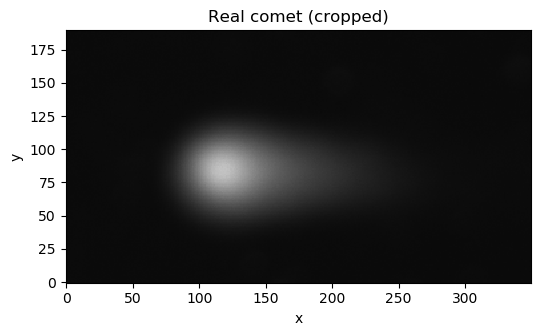

 
Date and time 2023-01-02 15:08:39.809892
Time since last check is 0:00:00.187065


In [7]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
print(" ")
#
# Coordinates (bottom left corner) and size of example comet
y0, dy0 = 510, 700
#y0, dy0 = 225, 280 #250, 310 #180, 280
#x0, dx0 = 210, 310 #210, 325 #50, 250
x0, dx0 = 800, 1150 #210, 325 #50, 250

p_cropped = p[y0:dy0, x0:dx0]
#
fig,ax = plt.subplots(1, figsize = (6, 4))
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title("Real comet (cropped)")
plt.imshow(p_cropped, origin='lower', cmap=plt.get_cmap('afmhot'), vmin=5, vmax=255)
#plt.gca().invert_yaxis()
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))    

Date and time  2023-01-02 15:08:45.669043
 


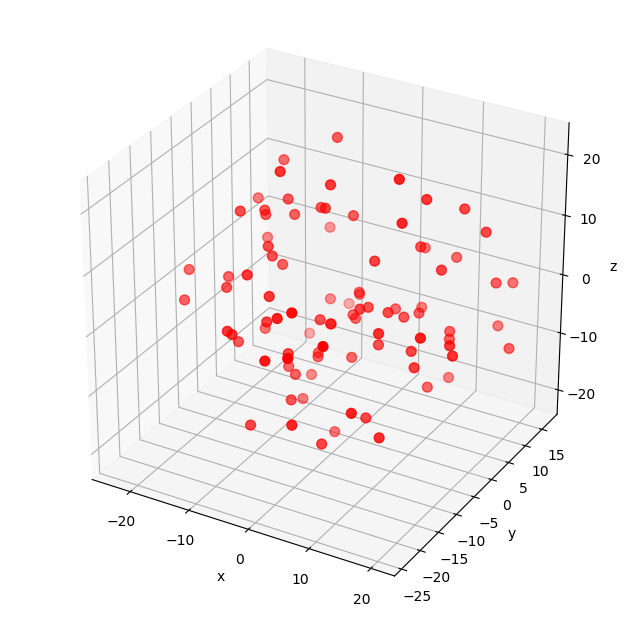

 
Date and time 2023-01-02 15:08:45.882602
Time since last check is 0:00:00.213559


In [8]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
print(" ")
#
nStrands = 92 #92
radCell = 25.0 # 35.0pixels 
# #
radArr = np.sqrt(np.random.uniform(0, radCell**2, nStrands))
phiArr = np.random.uniform(0, 2*np.pi, nStrands)
thetaArr = np.arccos(np.random.uniform(-1, 1, nStrands))
xArr = radArr*np.sin(thetaArr)*np.cos(phiArr)
yArr = radArr*np.sin(thetaArr)*np.sin(phiArr)
zArr = radArr*np.cos(thetaArr)
#
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
#ax.set_title('Positions of strands')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(xArr, yArr, zArr, color = 'r', s = 50.0)
#
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))    

Assume that each strand consists of a large number of points that are clustered around the strand's position. The smearing of the position of these points is assumed to follow a Gaussian distribution with RMS `smearWhole`. Some of the strands are assumed to be broken, with a probability `pBreak`. These can then stretch out along the $x$ axis (the electric field direction). The distance they stretch is taken to follow a uniform disrtibution in the range $0 < \delta x < $ `maxStretch`. The points representing the strand are spread out along this length. Points associated with broken strands are also assumed to be less tightly clustered: the RMS of their Gaussian distribution is `smearBreak`. Look at the resulting densities of points. It is assumed that these are what causes the variations in intensity in the comet images. The first image below shows the raw density of points in 2D histogram bins that represent image pixels. A threshold `cutIntensity` (representing the situation where no light penetrates the image) is applied to the second image.

Date and time  2023-01-02 15:08:48.228762
 
 
Image has 130 rows and 250 columns
Number of strand breaks is 58
Shape:, (190, 350, 3)
Min:9, Max:196


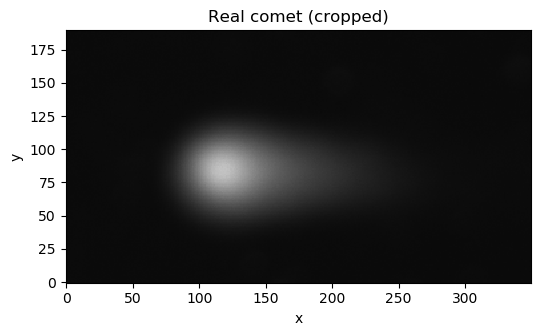

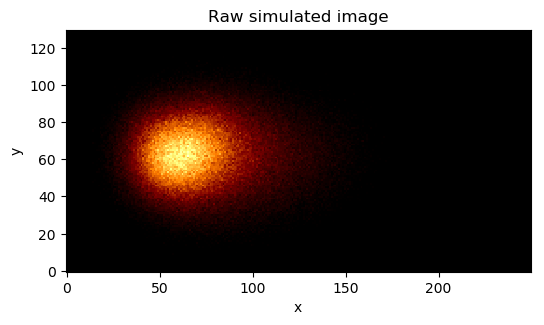

Max intensity:232.0


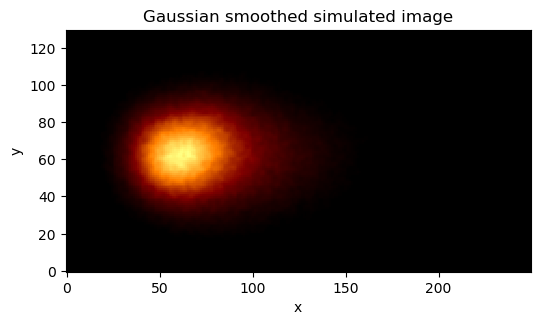

Max intensity:195.94669108888104


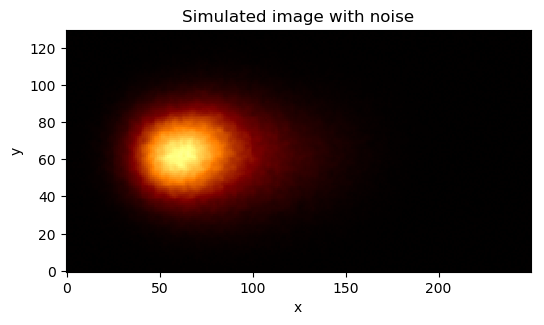

Max intensity:201.56510623346523
shape of h2d noisy is:  (130, 250)
 
Date and time 2023-01-02 15:08:49.002673
Time since last check is 0:00:00.773911


In [9]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
print(" ")
pBreak = 0.675 # probability a strand is broken; controls the spread of DNA in both x- and y-directions.
strWgt = int(5000) #int(8800)/ 8300 # number of parts in each strand; controls the peak intensity of the cell and tail.
maxStretch = 3.75*radCell # 3.75 extent of the tail.
smearBreak = 0.65*radCell # 0.45 broken strands have less tightly clustered points so RMS is higher - more variance than smearWhole.
smearWhole = 0.45*radCell # 0.45 RMS of the gaussian giving the smearing of strand positions.

# Semi-arbitrary size of the image. Chosen to comfortably fit an average real comet from the image.
nRows = 130 # 30
nCols = 250 # nRows*int((1 + maxStretch/(2*radCell)))
#
iBreak = (np.random.uniform(0, 1, nStrands) < pBreak).astype(int)
nBreaks = np.sum(iBreak)
print(" ")
print("Image has",nRows,"rows and",nCols,"columns")
print("Number of strand breaks is",nBreaks)
#
# rBins = np.linspace(-radCell, radCell, nRows + 1)
# cBins = np.linspace(-radCell, radCell + maxStretch, nCols + 1)
rBins = np.linspace(-nRows/2, nRows/2, nRows + 1) # Vertical image pixels decoupled from the size of the cell
cBins = np.linspace(-nCols/2, nCols/2, nCols + 1) + 65.0 # Horizontal image pixels, plus a manual offset to place the cell on the left-side of image. 
#
xArrInt = np.zeros((nStrands, strWgt))
yArrInt = np.zeros((nStrands, strWgt))
#
for n in range(0, nStrands):  
    xArrInt[n, 0:strWgt] = (xArr[n] + iBreak[n]*np.linspace(0, np.random.uniform(0, maxStretch, 1)[0], strWgt) + 
                            iBreak[n]*np.random.normal(0.0, smearBreak, strWgt) + 
                            (1 - iBreak[n])*np.random.normal(0.0, smearWhole, strWgt))
    yArrInt[n, 0:strWgt] = (yArr[n] + iBreak[n]*np.random.normal(0.0, smearBreak, strWgt) + 
                            (1 - iBreak[n])*np.random.normal(0.0, smearWhole, strWgt))
#
xArrHist = np.reshape(xArrInt, nStrands*strWgt)
yArrHist = np.reshape(yArrInt, nStrands*strWgt)
#
h2d, cEdges, rEdges = np.histogram2d(xArrHist, yArrHist, [cBins, rBins])
#
fig,ax = plt.subplots(1, figsize = (6, 4))
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title("Real comet (cropped)")
print("Shape:, {}".format(np.shape(p_cropped)))
print("Min:{}, Max:{}".format(np.min(p_cropped), np.max(p_cropped)))
#
# Show image with a set intensity range; important to keep it the same as real image, otherwise comparison to real image is misleading.
plt.imshow(p_cropped, origin='lower', cmap=plt.get_cmap('afmhot'), vmin=5, vmax=255)
plt.show()
# plt.savefig("real_comet_cropped.png")
# 
# Raw simulated image. Looks grainy due to lack of correlation between adjacent pixels
fig,ax = plt.subplots(1, figsize = (6, 4))
plt.title("Raw simulated image")
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.imshow(np.transpose(h2d), origin='lower', cmap=plt.get_cmap('afmhot'), vmin=5, vmax=255)
plt.show()
print("Max intensity:{}".format(np.max(h2d)))
# 
# Apply some gaussian smoothing to correlate these pixels (sigma chosen by trial and error)
h2d_gf = gaussian_filter(h2d, sigma=1.03)
fig,ax = plt.subplots(1, figsize = (6, 4))
plt.title("Gaussian smoothed simulated image")
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.imshow(np.transpose(h2d_gf), origin='lower', cmap=plt.get_cmap('afmhot'), vmin=5, vmax=255)
plt.show()
print('Max intensity:{}'.format(np.max(h2d_gf)))
#
# Real image does not have any zero-value pixels; it has a noise background. Let's introduce this in the form of Gaussian noise.
h2d_df_reshape = h2d_gf.reshape(nCols, nRows, 1) # noisy takes in a multi-channel (colour) image. So we reshape the array to specify 1 channel.
h2d_gf_noisy_temp = noisy('gauss', h2d_df_reshape)
h2d_gf_noisy = np.transpose(h2d_gf_noisy_temp.reshape(nCols, nRows))
fig,ax = plt.subplots(1, figsize = (6, 4))
plt.title("Simulated image with noise")
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.imshow(h2d_gf_noisy, origin='lower', cmap=plt.get_cmap('afmhot'), vmin=5, vmax=255)
plt.show()
print('Max intensity:{}'.format(np.max(h2d_gf_noisy)))
# plt.savefig("model_comet_cropped.png")
print("shape of h2d noisy is: ", h2d_gf_noisy.shape)
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))    

# Plot a histogram of all pixels in the image

Date and time  2023-01-02 15:08:55.117191
 


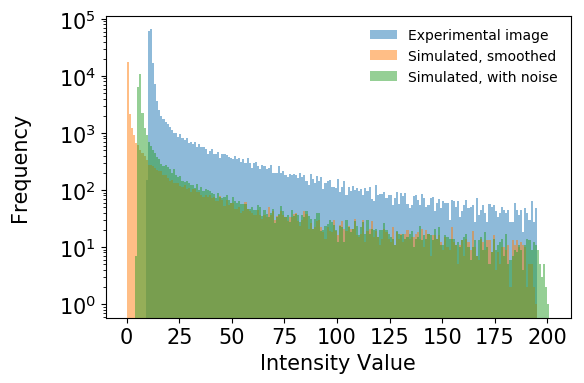

 
Date and time 2023-01-02 15:08:57.345956
Time since last check is 0:00:02.228765


In [10]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
print(" ")
#

fig, ax = plt.subplots(1, figsize = (6, 4))
n, bins, patches = ax.hist(p_cropped.flatten(), bins=np.arange(0, np.max(p_cropped), 1), log=True, alpha=0.5, label='Experimental image')
n, bins, patches = ax.hist(h2d_gf.flatten(), bins=np.arange(0, np.max(h2d_gf), 1), log=True, alpha=0.5, label='Simulated, smoothed') # has 0-valued pixels
n, bins, patches = ax.hist(h2d_gf_noisy.flatten(), bins=np.arange(0, np.max(h2d_gf_noisy), 1), log=True, alpha=0.5, label='Simulated, with noise')
ax.legend(loc='best', frameon=False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Intensity Value", fontsize = 15)
plt.ylabel("Frequency\n", fontsize = 15)
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then)) 

Now make an image like those produced at Clatterbridge by spreading a number `nCells` of cells/nuclei over the relevant area. Changing the probability of a strand break and tuning other parameters might give us images like the control and irradiated samples we have from Jason!

Date and time  2023-01-02 15:41:34.600830
 
 
Image 0
Number of cells to be simulated is:  5


/home/selina/anaconda3/envs/tfenv/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


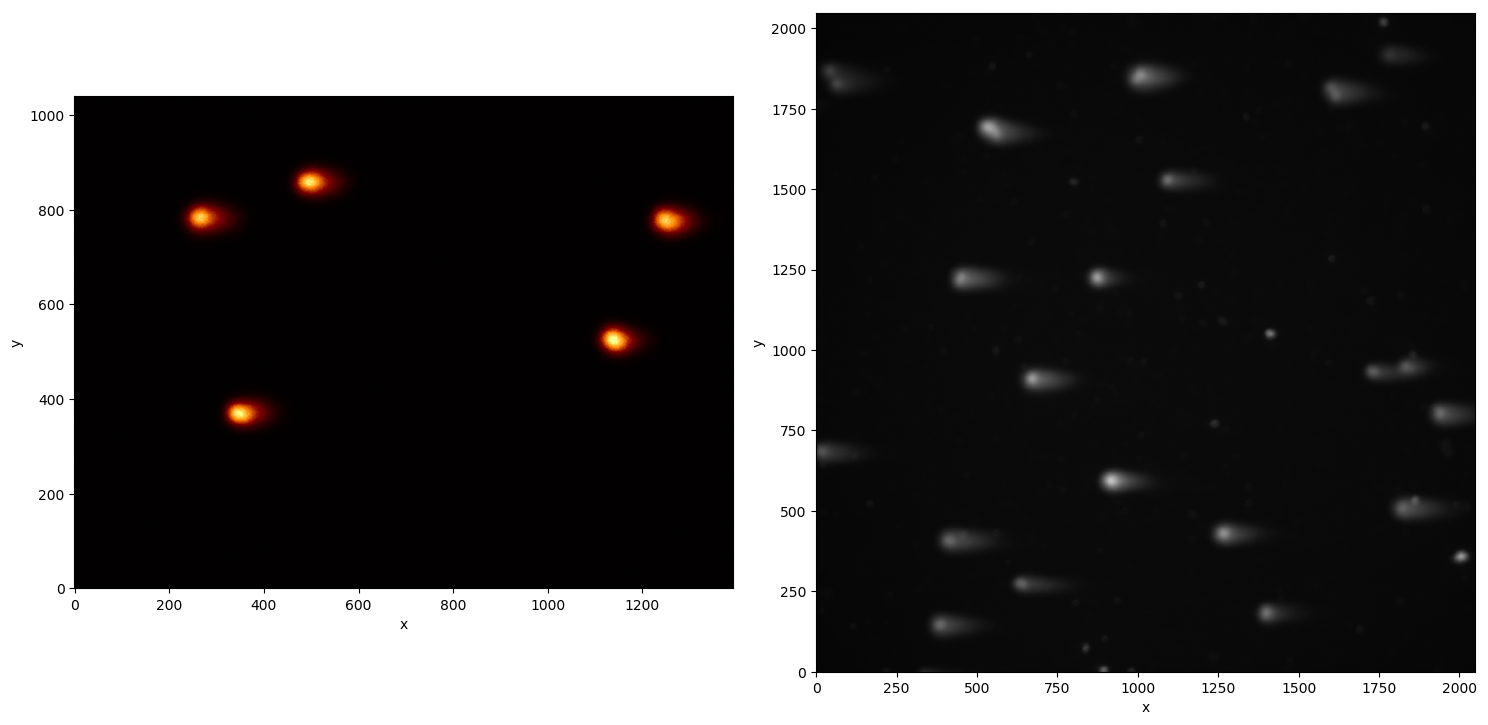

Write image MCimage000.bmp


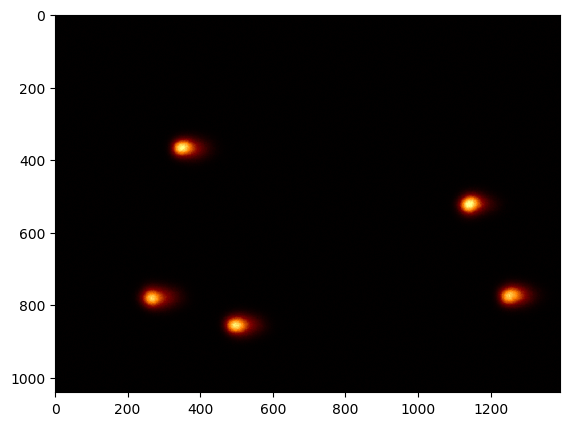

 
Maximum intensity in image 235.0
 
Image 1
Number of cells to be simulated is:  17


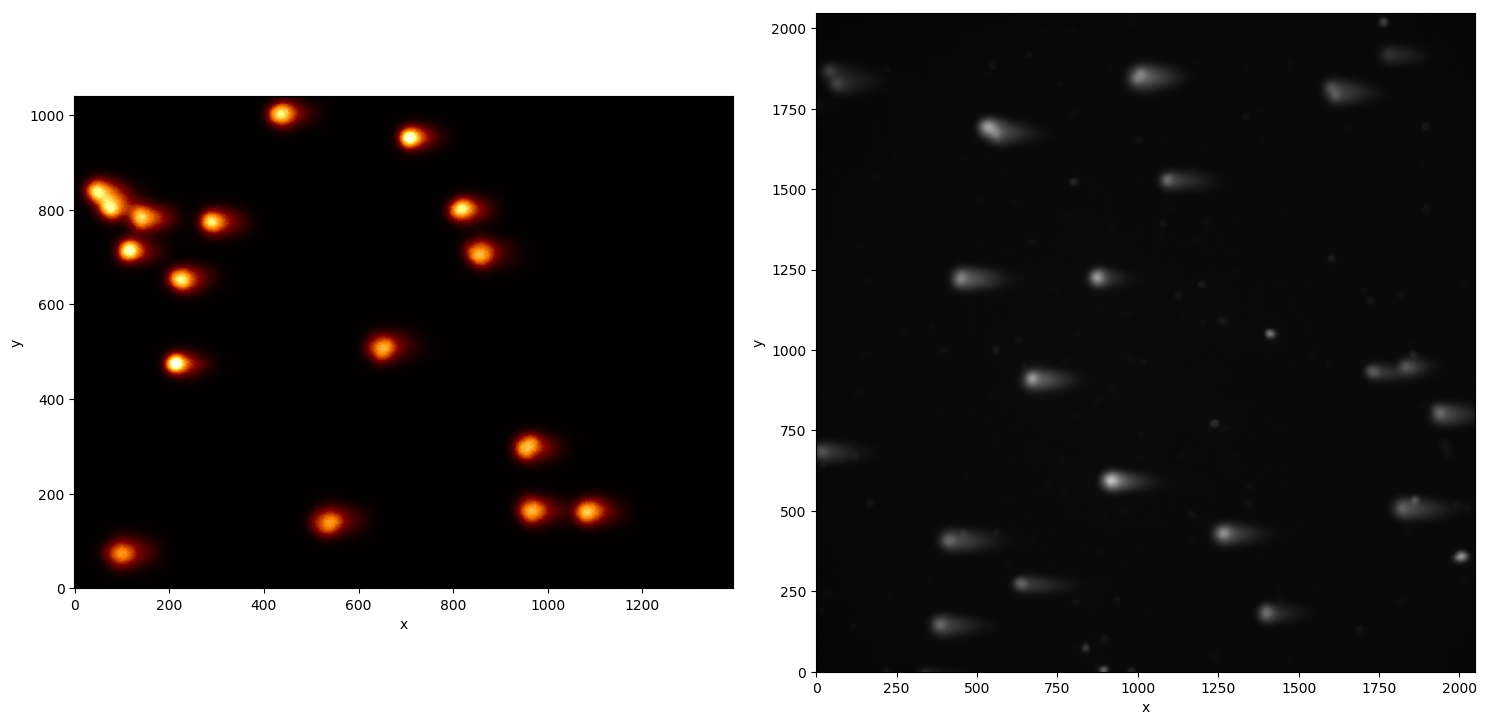

Write image MCimage001.bmp


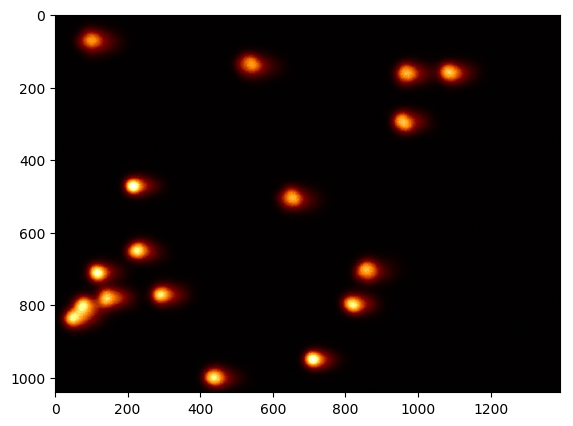

 
Maximum intensity in image 287.0
 
Image 2
Number of cells to be simulated is:  11


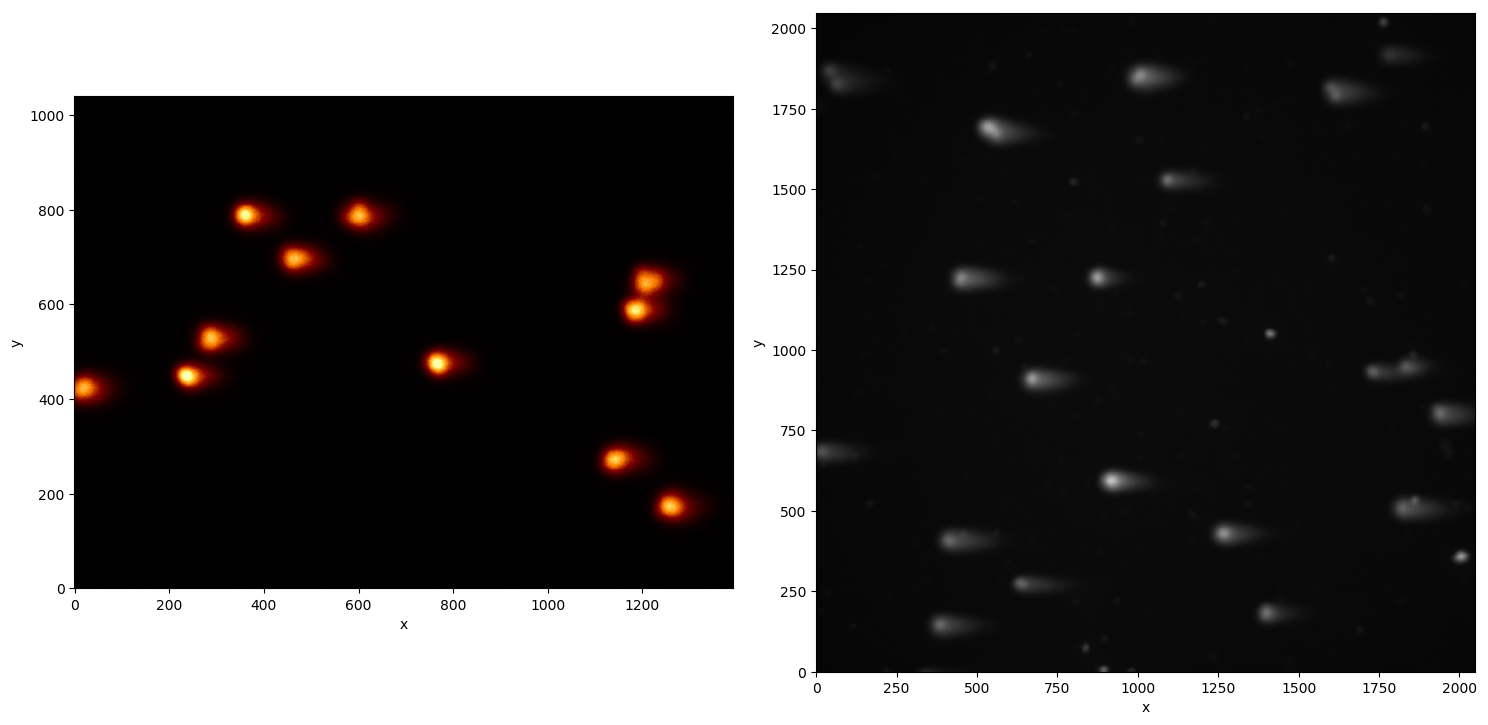

Write image MCimage002.bmp


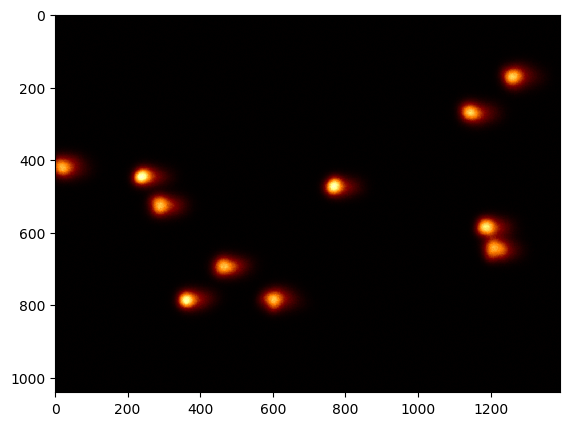

 
Maximum intensity in image 271.0
 
Number of images not simulated due to invalid number of comets is:  0
 
Date and time 2023-01-02 15:41:43.415844
Time since last check is 0:00:08.815014


In [16]:
from skimage.io import imsave
import cv2
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
print(" ")

write = False
#
nStrands = 92
pBreak = 0.675 # probability a strand is broken; controls the spread of DNA in both x- and y-directions.
strWgt = int(5000) #int(8800)/ 8300 # number of parts in each strand; controls the peak intensity of the cell and tail.
maxStretch = 3.75*radCell # 3.75 extent of the tail.
smearBreak = 0.65*radCell # 0.45 broken strands have less tightly clustered points so RMS is higher - more variance than smearWhole.
smearWhole = 0.45*radCell # 0.45 RMS of the gaussian giving the smearing of strand positions.
# loop to produce nImages images
nImages = 3
mean = 13
stdev = 5.59
errCount = 0 
for nI in range (0, nImages):
    nCells = int(np.random.normal(loc = mean, scale = stdev))
    if nCells < 5 or nCells > 30:
        print("ERROR: Invalid number of comets. This image will not be simulated")
        errCount += 1
        continue
    print(" ")
    print("Image",nI)
    print("Number of cells to be simulated is: ", nCells)
    nRows_tot = 1040
    nCols_tot = 1392
    #
    xCell = np.random.uniform(0, nCols_tot, nCells + 1)
    yCell = np.random.uniform(0, nRows_tot, nCells + 1)
    #
    rowBins = np.linspace(0.0, nRows_tot, nRows_tot + 1)
    colBins = np.linspace(0.0, nCols_tot, nCols_tot + 1)
    #
    rMin = 0.2
    sigCell = radCell/4.0
    #
    xTotal = np.zeros(nCells*nStrands*strWgt)
    yTotal = np.zeros(nCells*nStrands*strWgt)
    #
    nBreakArr = np.zeros((nCells, nStrands))
    #
    h2dTotal = np.zeros((nCols_tot, nRows_tot))

    for nC in range(0, nCells):
        radArr = np.sqrt(np.random.uniform(0, max(np.random.normal(radCell, sigCell, 1)**2, rMin**2), nStrands))
#        radArr = np.sqrt(np.random.uniform(0, radCell**2, nStrands))
        phiArr = np.random.uniform(0, 2*np.pi, nStrands)
        thetaArr = np.arccos(np.random.uniform(-1, 1, nStrands))
        xArr = xCell[nC] + radArr*np.sin(thetaArr)*np.cos(phiArr)
        yArr = yCell[nC] + radArr*np.sin(thetaArr)*np.sin(phiArr)
        for n in range(0, nStrands):
            fragments = 1
            strandBreaks = np.zeros(strWgt - 1)
            #for n in range(0, strWgt):
            strandBreaks[:] = (np.random.uniform(0, 1, strWgt - 1) < pBreak).astype(int)
            sumBreaks = np.sum(strandBreaks)
            nBreakArr[nC, n] = sumBreaks
            fragments += sumBreaks
            iBreak[0:nStrands] = (np.random.uniform(0, 1, nStrands) < pBreak).astype(int)
            nBreakArr[nC] = np.sum(iBreak)
            xArrInt[n, 0:strWgt] = (xArr[n] + iBreak[n]*np.linspace(0, np.random.uniform(0, maxStretch, 1)[0], strWgt) + 
                                    iBreak[n]*np.random.normal(0.0, smearBreak, strWgt) + 
                                    (1 - iBreak[n])*np.random.normal(0.0, smearWhole, strWgt))
            yArrInt[n, 0:strWgt] = (yArr[n] + iBreak[n]*np.random.normal(0.0, smearBreak, strWgt) + 
                                    (1 - iBreak[n])*np.random.normal(0.0, smearWhole, strWgt))
    #
        iBreak[0:nStrands] = (np.random.uniform(0, 1, nStrands) < pBreak).astype(int)
        xArrHist = np.reshape(xArrInt, nStrands*strWgt)
        yArrHist = np.reshape(yArrInt, nStrands*strWgt)
        #
        h2d, cEdges, rEdges = np.histogram2d(xArrHist, yArrHist, [colBins, rowBins])
        #
        h2dTotal = h2dTotal + h2d
    #
    rMid = (rEdges[0:nRows_tot] + rEdges[1:nRows_tot + 1])/2
    cMid = (cEdges[0:nCols_tot] + cEdges[1:nCols_tot + 1])/2
    maxIntensity = np.amax(h2dTotal)

    h2dTotal_gf = gaussian_filter(h2dTotal, sigma=1.05)
    h2dTotal_df_reshape = h2dTotal_gf.reshape(nCols_tot, nRows_tot, 1)
    h2dTotal_gf_noisy_temp = noisy('gauss', h2dTotal_df_reshape)
    h2dTotal_gf_noisy = np.transpose(h2dTotal_gf_noisy_temp.reshape(nCols_tot, nRows_tot))
    #
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), tight_layout=True)
    ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax2.set_xlabel('x'); ax2.set_ylabel('y')
    ax1.imshow(h2dTotal_gf_noisy, origin='lower', cmap=plt.get_cmap('afmhot'), vmin=5, vmax=255)
    ax2.imshow(p, origin='lower', cmap=plt.get_cmap('afmhot'), vmin=5, vmax=255)
    plt.show()
    #
    # Save simulated image to file
    if write:
        plt.figure(figsize = (8, 5))
        plt.imshow(h2dTotal_gf_noisy, interpolation = 'nearest', cmap=plt.get_cmap('afmhot'), vmin=5, vmax=255)
        outFile = "MCimage" + str(nI).zfill(3) + ".bmp"
        print("Write image",outFile)
        cv2.imwrite(outFile, h2dTotal_gf_noisy)
        #plt.imsave(outFile, h2dTotal_gf_noisy, format="bmp", cmap=plt.get_cmap('afmhot'), vmin=5, vmax=255)
        plt.show()
    print(" ")
    print("Maximum intensity in image",maxIntensity)
#
print(" ")
print("Number of images not simulated due to invalid number of comets is: ", errCount)
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))    

In [9]:
!ls Images/MCdata

ls: cannot access 'Images/MCdata': No such file or directory
